<a href="https://colab.research.google.com/github/CT-Cultures/Content/blob/master/RegOverview_Issue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Mount Drive
import os
import sys
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# [1] Setting up Environment and Install Requirements

In [4]:
%%capture
!pip install -r sources/ChinaFilm/requirements.txt
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

!pip install transformers

In [59]:
# Load Module
import os
import gc
import pandas as pd
from bs4 import BeautifulSoup
import re
import datetime 

from IPython.display import display, HTML

import jieba.analyse
tfidf = jieba.analyse.extract_tags
textrank = jieba.analyse.textrank
import jieba.posseg as pseg

import torch

import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.font_manager as fm

path_fonts = '/content/drive/MyDrive/Github/Article/fonts'
fontprop = fm.FontProperties(fname=path_fonts, size= 15)

font_dirs = [path_fonts, ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)
font_list = fm.createFontList(font_files)
for font in font_files:
  fm.fontManager.addfont(font)

plt.rcParams['figure.figsize'] = [15, 9]
mp.rcParams['font.family'] = ['Microsoft YaHei']

%matplotlib inline

# Load Local Lib# Set Path
path_wd = '/content/drive/MyDrive/Github/Content'
os.chdir(path_wd)

from sources.NRTA.Record_Registration import Registration # assume relative path at path_wd

tv_reg = Registration()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


In [142]:
# Set Path
path_records = '/content/drive/MyDrive/Github/Article/records'
# Set Path
path_wd = '/content/drive/MyDrive/Github/Article'
path_font = '/content/drive/MyDrive/Github/Article/fonts/STHUPO.TTF'
path_img = '/content/drive/MyDrive/Github/Article/img'
path_reg = '/content/drive/MyDrive/Github/Content/sources/NRTA'

#os.chdir(path_wd)

## 1.3 Load Latest Registration Publication

In [7]:
os.chdir(path_wd + '/sources/NRTA')
#!python Update_Registration.py # WIP

In [8]:
os.chdir(path_wd + '/sources/NRTA')
##########################################

fp = '/content/drive/MyDrive/Github/Content/sources/NRTA/records/contents_of_registrations.json'
df = pd.read_json(fp)

'2021年6月'

In [25]:
# update records to latest

links_of_publications = tv_reg.links_of_publications()

links_of_new_publications = \
  links_of_publications[~links_of_publications.公示名称.isin(df.公示名称)]

links_of_new_registrations = \
  tv_reg.links_of_registrations(links_of_new_publications)

contents_of_new_registrations = \
  tv_reg.contents_of_registrations(links_of_new_registrations)

contents_of_registrations_latest = \
  pd.concat([df, contents_of_new_registrations], ignore_index=True, axis=0)

contents_of_registrations_latest = \
  contents_of_registrations_latest.sort_values(
      '公示年月', ascending=False).reset_index(drop=True)

# save updates with backup
tv_reg.save_records(contents_of_registrations_latest, 'contents_of_registration')

------50------槐花情--------
------100------江流天地外--------


In [36]:
df = contents_of_registrations_latest
curr_issue_dt = df.sort_values(['公示年月'], ascending=False)['公示年月'].iloc[0]
issue_name = str(curr_issue_dt)
issue_name

'2021年9月'

In [42]:
# clean df, run mulitple times as necessary
df['许可证号'] = df['许可证号'].apply(lambda x:
                    x.lstrip('\n+').lstrip('\t+').lstrip('\w+').rstrip('\t+').rstrip('\n+'))
df['备注'] = df['备注'].apply(lambda x:
                    x.lstrip('\n+').lstrip('\t+').lstrip('\w+').rstrip('\t+').rstrip('\n+'))

In [43]:
df_curr = df[df['公示年月'] == curr_issue_dt].copy()
print(df_curr.columns)

Index(['剧名', '集数', '报备机构', '题材', '内容提要', '公示年月', '许可证号', '体裁', '拍摄日期', '制作周期',
       '省级管理部门备案意见', '相关部门意见', '备注', '公示年', '地区', '备案链接', '公示名称', '公示批次链接'],
      dtype='object')


#[2] Load Model for Predictons


## [2.1] Extract top keywords

In [44]:
df_curr['kw'] = df_curr['内容提要'].apply(textrank, topK=10)

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.048 seconds.
Prefix dict has been built successfully.


In [ ]:
df_curr['kw'].to_numpy()

## [2.2] Load Title Prediction Model

In [46]:
%%capture
from transformers import BertTokenizer, BartForConditionalGeneration

# assign device
if torch.cuda.device_count() > 0:
  device = 'cuda:' + str(torch.cuda.current_device())
else:
  device = 'cpu'

# Instantiate tokenizer and model
checkpoint = "/content/drive/MyDrive/Github/Content/tools/models/PredTitle-10000"

tokenizer = BertTokenizer.from_pretrained(checkpoint)
model = BartForConditionalGeneration.from_pretrained(checkpoint)
model.to(device)
model.eval()

In [47]:
batch_size = 8
i = 0
ls = df_curr['内容提要'].tolist()
L = df_curr.shape[0]
test_predictions = []

while i < L:
  inputs = tokenizer(ls[i:i+batch_size],
                           padding=True,
                           max_length=512, 
                           truncation=True, 
                           return_tensors='pt')
  inputs.to(device)
  summary_ids = model.generate(input_ids=inputs['input_ids'],
                             num_beams=4,
                             min_length=0,
                             max_length=32
                             )
  
  ret = [tokenizer.decode(g, 
                         skip_specical_tokens=True, 
                         clean_up_tokenization_spaces=True) for g in summary_ids]
  test_predictions.extend(ret)
  i += batch_size

In [48]:
df_curr['预测剧名'] = test_predictions

def remove_specials(x):
  x = re.sub(' ', '', x)
  x = re.sub('\[CLS\]', '', x)
  x = re.sub('\[PAD\]', '', x)
  x = re.sub('\[SEP\]', '', x)
  x = re.sub('\[UNK\]', '', x)
  return x

df_curr['预测剧名'] = df_curr['预测剧名'].apply(remove_specials)

In [49]:
df_curr['预测剧名'].to_numpy()

array(['超忆症', '日出街', '西迁风云', '大运河', '小花生', '许半夏', '乡村振兴', '潜艇', '渭南人家',
       '烽火天目山', '星城法院', '火线', '开路先锋', '绿水青山', '雪域高原', '星光厂长', '琉璃传奇',
       '刑侦队长', '我们的乡村', '企划三部', '我们的青春', '党旗', '木槿花开', '惊天计划', '我们的邻居',
       '一家人', '家的温暖与坚守', '厉山海', '谢小蝶传奇', '民法典', '厨痴', '国家公务员（第二季）',
       '天下第一码头', '乒乓少年', '天下第一夫妻', '高铁工程局', '紫金山', '中心商务区', '我的生育日记'],
      dtype=object)

## [2.3] 识别主要角色

In [52]:
df_curr['time'] = df_curr['题材'].apply(lambda x: x[0:2])
df_curr['genre'] = df_curr['题材'].apply(lambda x: x[2:])

df_curr['制作周期_月'] = df_curr['制作周期'].apply(lambda x: int(x.rstrip('个月')))

def months_to_principal_photography(x: pd.Series):
  year = int(x.split('.')[0])
  month = int(x.split('.')[1])
  now = datetime.datetime.now()
  p_date = datetime.date(year, month, 15)
  months_from_now = (p_date - now.date()).days // 30
  return months_from_now

df_curr['距离开机'] = df_curr['拍摄日期'].apply(months_to_principal_photography)
#df_curr['预估拍摄速度'] = df_curr['制作周期_月'] / df_curr['集数']*30

In [53]:
import jieba
import jieba.posseg as pseg
jieba.enable_paddle() #启动paddle模式。 0.40版之后开始支持，早期版本不支持

Installing paddle-tiny, please wait a minute......
Paddle enabled successfully......


In [54]:
# 识别主要角色
def find_PER(x: pd.Series):
  words = pseg.cut(x, use_paddle=True)
  ls_PER = []
  for word, flag in words:
    if flag == 'PER':
      word = word.strip('[\s,，。、“”？；]')
      ls_PER.append(word)
  ls_PER = list(set(ls_PER))

  ls_PER1 = ls_PER.copy()
  ls_PER = []
  while ls_PER1:
    PER =  ls_PER1.pop(0)
    ls_tmp = re.split('[\s,，。、“”？；]', PER)
    ls_PER.extend(ls_tmp)

  ls_PER = list(set(ls_PER)) 
  ls_PER = [PER for PER in ls_PER if len(PER) > 1]
  ls_PER_sorted = sorted(ls_PER, reverse=False, key=lambda x: len(x))

  ans = []
  while ls_PER_sorted:
    PER = ls_PER_sorted.pop(0)
    i = 0
    while i < len(ls_PER_sorted):
      if re.search(PER, ls_PER_sorted[i]):
        ls_PER_sorted.pop(i)
        ans.append(PER)
      i += 1
    if PER not in ans:
      ans.append(PER)

  return ans

df_curr['主要角色'] = df_curr['内容提要'].apply(find_PER)

In [55]:
df_curr['主要角色'].to_numpy()

array([list(['老罗', '邢强', '林楠', '维美', '杰克唐', '詹姆斯', '江伟杰', '郝爱国']),
       list(['佟母', '陈要武', '林海燕', '佟铁军', '姚玉玲', '陈母鲁大英']),
       list(['梅麟', '薪火', '张昭如', '胡复信']), list(['路长河']),
       list(['林旭', '肖卉芸']), list(['万难', '许半夏']), list(['尤唯实', '雷梅蕊']),
       list(['沈白露', '张家明', '罗天江', '刘有志']),
       list(['宋渭南', '关世杰', '宋英杰', '李华山', '杨连发', '蔺焕荣']),
       list(['占彪', '袁丹云', '新四军']), list(['施艺', '徐天', '孙哲', '罗远翔', '刘晓娴']),
       list(['韩梓川']), list(['叶岚', '长罗', '马祖堂']),
       list(['古柏', '刘海东', '蒋泽金', '付悦玥']),
       list(['余淼', '杨红霞', '格萨尔', '杨县长', '杨小军', '安吉拉', '扎西泽仁']),
       list(['郝云东']), list(['金坚', '琴瑟', '苏海', '琉璃', '苏南瑾', '麴崇裕', '裴行俭']),
       list(['方源', '武公大', '白铭宇']), list(['张德美', '赵欲海', '王志成']),
       list(['吴意美', '白马帅', '范思思', '李天然']), list([]),
       list(['李健', '傅雪莲', '方志义']), list(['欧父', '白雪梅', '辛医生']),
       list(['谢娟', '黎剑', '杨光', '方特', '赵亚苧']), list(['乔智', '黄大雄']),
       list(['马鸣', '罗刚', '林静', '罗康', '罗健', '黄蓉', '马大利']),
       list(['郑西', '小胜', '东霓', '江薏', '

# [2] Generating Article Contents

##[2.1] 2021年X月电视剧备案划重点

In [56]:
# Title
T1 = '{}电视剧备案划重点'.format(df_curr['公示年月'].iloc[0])

print(T1)

2021年9月电视剧备案划重点


In [57]:
dfview = df_curr[[
                   '剧名', '集数', '距离开机', 'genre', 
                   'time', '主要角色', '报备机构', '内容提要',
                   '预测剧名', 'kw']].sort_values('距离开机')
dfview.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39 entries, 26 to 33
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   剧名      39 non-null     object
 1   集数      39 non-null     object
 2   距离开机    39 non-null     int64 
 3   genre   39 non-null     object
 4   time    39 non-null     object
 5   主要角色    39 non-null     object
 6   报备机构    39 non-null     object
 7   内容提要    39 non-null     object
 8   预测剧名    39 non-null     object
 9   kw      39 non-null     object
dtypes: int64(1), object(9)
memory usage: 3.4+ KB


In [76]:
df_by_genre

,genre,数量
0,传奇,3
1,其它,8
2,军旅,1
3,农村,4
4,武打,1
5,涉案,4
6,都市,16
7,革命,2


## 按类型划分

<Figure size 432x252 with 0 Axes>

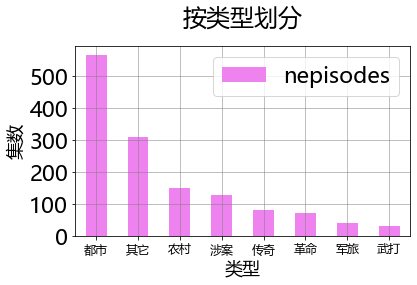

In [98]:
df_by_genre_episode = \
  dfview.groupby('genre')['集数'].sum().rename('nepisodes'
  ).reset_index().sort_values('nepisodes', ascending=False)

plt.clf()
plt.rcParams['figure.figsize'] = [6, 3.5]
plt.rcParams['axes.facecolor'] = 'white'
ax = df_by_genre_episode.plot(
    kind = 'bar',
    grid = True,
    fontsize = 22,
    rot = 0,
    color = ['violet'],
)
ax.set_title("按类型划分",fontsize= 24, pad=20)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
ax.grid(color='gray', linestyle='-', linewidth=0.5)
ax.set_xlabel('类型',fontsize= 18)
ax.set_xticklabels(df_by_genre['genre'], fontsize=12)
ax.set_ylabel("集数",fontsize= 18)
ax.legend(fontsize=22)

fp_plot_time = path_img + '/df_TVReg_plot_genre_by_nepisodes_{}.png'.format(issue_name)
plt.savefig(fp_plot_time, bbox_inches='tight')

plt.show()

<Figure size 432x252 with 0 Axes>

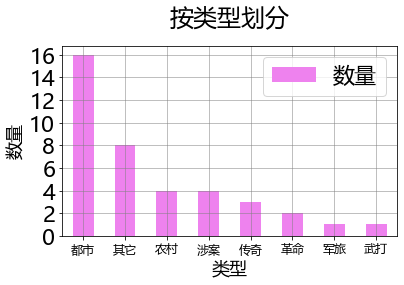

In [79]:
# WIP
df_by_genre= dfview.groupby('genre')['genre'].count(
    ).rename('数量').reset_index().sort_values('数量', ascending=False)

plt.clf()
plt.rcParams['figure.figsize'] = [6, 3.5]
plt.rcParams['axes.facecolor'] = 'white'
ax = df_by_genre.plot(
    kind = 'bar',
    grid = True,
    fontsize = 22,
    rot = 0,
    color = ['violet'],
)
ax.set_title("按类型划分",fontsize= 24, pad=20)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
ax.grid(color='gray', linestyle='-', linewidth=0.5)
ax.set_xlabel('类型',fontsize= 18)
ax.set_xticklabels(df_by_genre['genre'], fontsize=12)
ax.set_ylabel("数量",fontsize= 18)
ax.legend(fontsize=22)

fp_plot_time = path_img + '/df_TVReg_plot_genre_by_n_{}.png'.format(issue_name)
plt.savefig(fp_plot_time, bbox_inches='tight')

plt.show()

##[2.2] 	本期通过备案的电视剧共计39部,估计已开机的1部,一个月内将开机的20部,距离开机一个月以上的18部。其中，20集(含）以下的电视剧又4部,20到40集的有35部,超过40集的有0部。


In [93]:
dfview.columns
dfview['集数'] = dfview['集数'].astype('int')

In [99]:
# Write Content
T2 = '\n'
T2 += '本期通过备案的电视剧共计{}部，'.format(dfview.shape[0])
T2 += '估计已开机的{}部，'.format(dfview[dfview['距离开机'] < 0].shape[0])
T2 += '一个月内将开机的{}部，'.format(
    dfview[(dfview['距离开机'] >= 0) & (dfview['距离开机'] < 2)].shape[0])

T2 += '距离开机一个月以上的{}部。'.format(
    dfview[(dfview['距离开机'] > 2)].shape[0])

T2 += '其中，20集(含）以下的电视剧有{}部，'.format(dfview[dfview['集数'] <= 20].shape[0])
T2 += '20到40集的有{}部，'.format(
    dfview[(dfview['集数'] > 20) & (dfview['集数'] <= 40)].shape[0])
T2 += '超过40集的有{}部。'.format(dfview[dfview['集数'] > 40].shape[0])

print(T2)


本期通过备案的电视剧共计39部，估计已开机的8部，一个月内将开机的19部，距离开机一个月以上的10部。其中，20集(含）以下的电视剧有1部，20到40集的有38部，超过40集的有0部。


##[2.3] 	本批次中，大数据分析识别出XX部上市影视公司关联项目，占比XX%。慷田AI聚焦关注的有

In [114]:
df_curr['报备机构'].unique()

array(['中视罗德（北京）国际文化传媒有限公司', '南京广播电视台', '浙文影业集团股份有限公司',
       '浙江东阳新媒诚品文化传媒有限公司', '浙江象山上象星作影视文化有限公司', '福建两极传媒有限公司',
       '青岛正月文化传播有限公司', '山东华友影视文化传媒有限公司', '河南鸿辉嘉映文化传媒有限公司', '潇湘电影集团有限公司',
       '四川星空影视文化传媒有限公司', '绵阳文化旅游集团有限公司', '四川省泰之韵影业有限公司', '初一影业（成都）有限公司',
       '四川八骏联盟影视文化传播有限公司', '陕西文投（影视）艺达文化传媒有限公司', '陕西文化产业（影视）投资有限公司',
       '宁夏海龙影视传媒有限公司', '江苏稻草熊影业有限公司', '成都茉莉花开文化传媒有限公司',
       '承德非凡影视文化传媒有限责任公司', '北京完美世界影视有限公司', '上海慈文影视传播有限公司',
       '北京华谊兄弟娱乐投资有限公司', '恒烁影业（北京）有限公司', '北京爱奇艺科技有限公司', '北京剧元气文化传媒有限公司',
       '北京电光灯影业有限公司', '北京天岸马文化传媒有限公司', '北京歌亮传媒有限公司', '煌程影业（北京）有限责任公司',
       '恒丰影业（北京）有限公司', '北京辰海文化传媒有限公司', '北京胖胖熊文化传媒有限公司', '北京鼎级华彩文化传媒有限公司',
       '上海亚太影视公司', '大唐风韵（北京）影视有限责任公司', '上海言叶之风影视传媒有限公司'], dtype=object)

In [ ]:
# 本批次中与上市影视公司关联的项目有
info_public_film_co = pd.read_csv('/content/drive/MyDrive/Github/Article/reference/info_public_film_co.csv', index_col=0, encoding='utf-8-sig')
ls = info_public_film_co['公司简称'].apply(eval).sum()
pat_public = '|'.join(ls)
pat_public += '|阿里|腾讯|爱奇艺|英皇|寰亚|银都|美亚|大盛|儒意|灿星|横店|华策|电视剧制作中心'
pat_public += '|得闲|芒果|新丽|欢乐|尚世|华策|稻草熊|东阳欢娱|耀客|湖南快乐阳光|山东影视制作|当代时光'
pat_public += '|唐德|欢瑞|优酷|嘉行|东阳欢愉|稻草熊'
df_focus = dfview.loc[dfview['报备机构'].str.contains(pat_public), :]
df_focus[['剧名','报备机构', '集数','内容提要', 'genre']]

In [118]:
ids = [2,3,4,16,19,22,23,24,26]
df_focus_narrowed = df_focus.loc[ids]

In [119]:
df_focus_narrowed['单位简称'] = df_focus_narrowed['报备机构'].str.extract('('+ pat_public + ")")

In [ ]:
df_focus_narrowed.info()

In [122]:
########
T3 = '\n'
T3 += '本批次中，大数据分析识别出{}部上市影视公司及国资参投影视公司关联项目，'.format(df_focus.shape[0])
T3 += '占比{}%。'.format(round((df_focus.shape[0]/df_curr.shape[0]*100),2))
T3 += '结合题材与出品方实力，慷田AI聚焦关注的有'

for i, row in df_focus_narrowed.iterrows():
  T3 += '{}的'.format(row['单位简称'])
  if i == df_focus_narrowed.index[-2]:
    T3 += '《{}》和'.format(row['剧名'])
  else:
    T3 += '《{}》、'.format(row['剧名'])
T3 = T3.rstrip('、') + '，'

T3 += '题材类型包括了{}。\n'.format(
    '、'.join(df_focus_narrowed['genre'].unique())
)
print(T3)


本批次中，大数据分析识别出10部上市影视公司及国资参投影视公司关联项目，占比25.64%。结合题材与出品方实力，慷田AI聚焦关注的有浙文的《文军西征》、浙文的《大运之河》、新媒的《人间告白》、文投的《风起西州》、稻草熊的《今日宜加油》、完美的《我在天堂等你》、慈文的《静谧之蓝》、华谊的《邻家爸爸》和爱奇艺的《龙城》，题材类型包括了其它、都市、传奇、涉案。



In [123]:
df_focus_narrowed.index[-2]

24

## [2.4] 生成词云图

In [124]:
df_focus_narrowed.index

Int64Index([2, 3, 4, 16, 19, 22, 23, 24, 26], dtype='int64')

In [136]:
os.chdir(path_wd)
#%load_ext autoreload
%reload_ext autoreload
from generate import utils

from IPython.display import Image as Img
from PIL import Image as pil
path_img = '/content/drive/MyDrive/Github/Article/img'

In [133]:
from IPython.display import Image as Img
from PIL import Image as pil

path_posters = '/content/drive/MyDrive/Github/Article/img/posters'
path_icon = '/content/drive/MyDrive/Github/Article/img/genre_icon'

#df_label2image.to_json(path_records + '/df_label2image.json')
df_label2image = pd.read_json(path_wd + '/records/df_label2image.json')

In [129]:
df_focus_narrowed['src_img'] = None
df_focus_narrowed['tgt_img'] = None

In [137]:
for i in df_focus_narrowed.index:
  ls = [df_focus_narrowed.loc[i, '剧名']] * 10
  ls += [df_focus_narrowed.loc[i, '预测剧名']] *6
  ls += df_focus_narrowed.loc[i, '主要角色']*3
  ls += [df_focus_narrowed.loc[i, 'genre']] *3
  ls += [df_focus_narrowed.loc[i, 'time']]*3
  ls += df_focus_narrowed.loc[i, 'kw']
  img_fn = df_focus_narrowed.loc[i, 'src_img']
  if not img_fn:
    img_fn = df_label2image.loc[
        df_label2image['label'] == df_focus_narrowed.loc[i, 'genre'],
        'fn'
    ].iloc[0]
  #print(txt)
  fp_img = path_img + '/genre_icon/{}'.format(img_fn)
  fp_mask = path_img + '/genre_icon/{}'.format('mask_' + img_fn)
  fp_img = path_img + '/genre_icon/{}'.format('psychedelic-1084082_960_720.jpg')
  fp_generated_img = utils.generate_word_image(ls, 
                                               fp_img, 
                                               fp_mask,
                                               fp_prefix='NRTA_TVReg_Overview',
                                               fp_suffix=issue_name,
                                               img_width=400,
                                               )
  display(Img(fp_generated_img, width=400))
  df_focus_narrowed.loc[i, 'tgt_img'] = fp_generated_img

Output hidden; open in https://colab.research.google.com to view.

##[2.5] 生成摘要

In [138]:
S0 = issue_name
S0 += '电视剧备案慷田AI聚焦关注的有'

for i, row in df_focus_narrowed.iterrows():
  S0 += '{}的'.format(row['单位简称'])
  if i == df_focus_narrowed.index[-2]:
    S0 += '《{}》和'.format(row['剧名'])
  else:
    S0 += '《{}》、'.format(row['剧名'])
S0 = S0.rstrip('、') + '，'

S0 += '题材类型包括了{}。\n'.format(
    '、'.join(df_focus_narrowed['genre'].unique())
)
print(S0)

2021年9月电视剧备案慷田AI聚焦关注的有浙文的《文军西征》、浙文的《大运之河》、新媒的《人间告白》、文投的《风起西州》、稻草熊的《今日宜加油》、完美的《我在天堂等你》、慈文的《静谧之蓝》、华谊的《邻家爸爸》和爱奇艺的《龙城》，题材类型包括了其它、都市、传奇、涉案。



##[2.6] 指向国家广电局官网


In [156]:
#####
R1 = '\n\n'
R1 += '慷田AI结合自主调研及多方大数据比对，通过分析、建模，提炼关键信息。'
R1 += '电视剧备案公示信息来自国家广播电视总局 National Radio and Televison Administration, 官方网址 '
R1 += ' http://www.nrta.gov.cn/ 。'

print(R1)



慷田AI结合自主调研及多方大数据比对，通过分析、建模，提炼关键信息。电影立项备案公示信息来自国家广播电视总局 National Radio and Televison Administration, 官方网址  http://www.nrta.gov.cn/ 。


In [157]:
R2 = '点击左下角阅读原文查看本期慷田AI电视剧信息详表。'
R3 = '点击左下角阅读原文查看本期慷田AI电视剧概览分析。'

In [140]:
issue_name

'2021年9月'

## [2.7] Save df of this issue pickle

In [143]:
df_curr.to_pickle(path_records + '/df_tvreg_{}.pkl'.format(issue_name))
df_focus_narrowed.to_pickle(path_records + '/df_tvreg_focus_{}.pkl'.format(issue_name))

In [ ]:
df_curr = pd.read_pickle(path_records + '/df_tvreg_{}.pkl'.format(issue_name))
df_focus_narrowed = pd.read_pickle(path_records + '/df_tvreg_focus_{}.pkl'.format(issue_name))

#[3] Output Word Document

## 3.1 Install and Load Libraries

In [144]:
%%capture
!pip install python-docx
!pip install lxml
from docx import Document
from docx.shared import Inches
#from docx.text.parargaph import Paragraph

In [145]:
df_focus_narrowed[['报备机构']]

,报备机构
2,浙文影业集团股份有限公司
3,浙文影业集团股份有限公司
4,浙江东阳新媒诚品文化传媒有限公司
16,陕西文投（影视）艺达文化传媒有限公司
19,江苏稻草熊影业有限公司
22,北京完美世界影视有限公司
23,上海慈文影视传播有限公司
24,北京华谊兄弟娱乐投资有限公司
26,北京爱奇艺科技有限公司


## 3.2 Output Docx


In [151]:
from docx import Document
from docx.shared import Inches
from docx.oxml.ns import qn

### Write Overview docx

In [177]:
path_doc = '/content/drive/MyDrive/Github/Article/docx'
path_img = '/content/drive/MyDrive/Github/Article/img'

doc = Document()

# Set document Font 
doc.styles['Normal'].font.name = '微软雅黑'
r = doc.styles['Normal']._element
r.rPr.rFonts.set(qn('w:eastAsia'), '微软雅黑')

# Set Document Title
doc.core_properties.title = 'China TV Registration Overview ' + issue_name

doc.add_heading(T1, 0)

p = doc.add_paragraph(S0, style='Intense Quote')

doc.add_paragraph(T2)
doc.add_paragraph(T3)

for i, row in df_focus_narrowed.iterrows():
  if  row['距离开机'] <= 0: pstatus = '估摸着已开机'
  elif  0 < row['距离开机'] <= 1: pstatus = '预计一个月内开机'
  else: pstatus = '预计距离开机1个月以上' 
  txt = '\n《{}》，{}集，{}。'.format(row['剧名'], row['集数'], pstatus)
  txt += '\n报备机构：{}'.format(row['报备机构'])
  txt += '\n主要角色：{}'.format('、'.join(row['主要角色']))
  doc.add_paragraph(txt)
  doc.add_picture(row['tgt_img'], width =Inches(4))
  doc.add_paragraph(row['内容提要'])

doc.add_paragraph(R1)
doc.add_paragraph(R2)

fp_doc = path_doc + '/TVregHighlight_' + issue_name + '.docx'
doc.save(fp_doc)


In [178]:
# Download Document
from google.colab import files
files.download(fp_doc)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### write Table docx

In [169]:
dfview.columns

Index(['剧名', '集数', '距离开机', 'genre', 'time', '主要角色', '报备机构', '内容提要', '预测剧名',
       'kw'],
      dtype='object')

In [170]:
doc = Document()

# Set document Font 
doc.styles['Normal'].font.name = '微软雅黑'
r = doc.styles['Normal']._element
r.rPr.rFonts.set(qn('w:eastAsia'), '微软雅黑')

# Set Document Title
doc.core_properties.title = 'China TV Registration Table ' + issue_name

doc.add_heading('详表：{}'.format(T1), 0)

p = doc.add_paragraph(S0, style='Intense Quote')

table = doc.add_table(rows=1, cols=1, style='Light List Accent 3')
i = 1
for _, row in dfview.iterrows():
  row_cells = table.add_row().cells
  row_cells[0].text = '[{}] '.format(i) + \
                      '《{}》，'.format(row['剧名']) + \
                      '{}集'.format(row['集数'])

  #if row['匹配片名'] != '':
  #  row_cells[0].text += ' (原备案名《{}》)'.format(row['匹配片名'])

  row_cells = table.add_row().cells
  row_cells[0].text = row['time'] + row['genre']
  
  if  row['距离开机'] <= 0: pstatus = '估摸着已开机'
  elif  0 < row['距离开机'] <= 1: pstatus = '预计一个月内开机'
  else: pstatus = '预计{}个月后开机'.format(row['距离开机'])
  row_cells = table.add_row().cells
  row_cells[0].text = pstatus
  #if row['是否修改'] == '是':
  #  row_cells[0].text += ', 修改后通过备案'

  row_cells = table.add_row().cells
  row_cells[0].text = '报备机构: {}'.format(row['报备机构'])

  row_cells = table.add_row().cells
  row_cells[0].text = '主要角色: {}'.format('、'.join(row['主要角色']))

  row_cells = table.add_row().cells
  row_cells[0].text = row['内容提要']

  row_cells = table.add_row().cells
  row_cells[0].text = ''
  i+=1

doc.add_paragraph(R1)
doc.add_paragraph(R3)

fp_doc = path_doc + '/TVregTable_' + issue_name + '.docx'
doc.save(fp_doc)


In [171]:
# Download Document
from google.colab import files
files.download(fp_doc)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>